In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc


In [2]:
data_dir_97 ='data/assembs_16s_97/'

list_16s_97 = [data_dir_97 + file for file in os.listdir(data_dir_97) if file.endswith('.fasta')]

csvs = [csv for csv in os.listdir(data_dir_97) if csv.endswith('.csv')]

covstats_dir = 'data/cov_stats/'
covstats = [cs for cs in os.listdir(covstats_dir)]

In [3]:

# Reads in bin and taxnmy from csv
# Removes Eukaryota entries 


def read_classify(csv_file):
    df = pd.read_csv(data_dir_97+csv_file, sep=';', usecols=['sequence_identifier','lca_tax_slv'])
    
    # Removes Eukaryota entries 
    drp_idx = df[df['lca_tax_slv'].apply(lambda x: True if x.split(';')[0] == 'Eukaryota' else False)].index
    df.drop(drp_idx, inplace=True)
    
    #Clean up seq_id and get the assembly for each bin 
    df['sequence_identifier'] = df['sequence_identifier'].apply(lambda x: x.split(':')[2])
    df['Assembly'] = [csv_file.split('_')[0]] * len(df)
    
    ## This is were we can grap Alpha and Gamma 
    df['phylum'] = df['lca_tax_slv'].apply(lambda x: x.split(';')[1])
    df['class'] = df['lca_tax_slv'].apply(lambda x: x.split(';')[2])
    df.loc[df['phylum']=='Proteobacteria', 'phylum'] = df['class']
    df.drop('class', axis=1)
    
    return df

In [4]:
contigs_df_97 = pd.concat([read_classify(csv) for csv in csvs]).reset_index(drop = True)
cov_stat_df = pd.concat([pd.read_csv(covstats_dir+cs, sep = '\t', usecols=['#ID', 'Avg_fold'],engine='python') for cs in covstats])
cov_stat_df.rename(columns={'#ID':'sequence_identifier'}, inplace=True)    
contigs_df_97_cov  = contigs_df_97.merge(cov_stat_df, on = 'sequence_identifier')

contigs_df_97_cov['Avg_fold'] = contigs_df_97_cov['Avg_fold'].astype(float)

In [5]:
df_lists = []

for assembly, df in contigs_df_97_cov.groupby('Assembly'):
    #proteo = df[df['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')
    ## Sort the remaingin phluym Phyla
    #not_prot = df[~df['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')
    
    #df = pd.concat([proteo,not_prot ], ignore_index=True)

    
    
    
    for phyla in df['phylum'].unique():
        total = df['Avg_fold'].sum()
        df_lists.append([assembly, phyla, (df[df['phylum']==phyla]['Avg_fold'].sum()/total)])
          
data_frame = pd.DataFrame(df_lists, columns=['Assembly', 'Phyla','Abundance']).set_index(['Assembly','Phyla'])

In [6]:
## Plot this df as a stacked barchart
#data_frame

color_map = {'Alphaproteobacteria':"#a6cee3",
 'Gammaproteobacteria':"#e3a6c9",
 'Acidobacteria':"#b2df8a",
 'Actinobacteria':"#ff9e3d",
 'Bacteroidetes':"#33a02c",
 'Cyanobacteria':"#cab2d6",
 'Dadabacteria':"#a561ed",
 'Kiritimatiellaeota':"#1f78b4",
 'Lentisphaerae':'#5d6d3c',
 'Nitrospirae':"#F47BE7",
 'PAUC34f':"#e3e34f", 
 'Planctomycetes':"#fb9a99",
 'Thaumarchaeota':"#e84f51"}


In [7]:
## Reorder the unstacked df to match the dictioary keys

# get keys (they come out in the right order!)
cm_keys = list(color_map.keys())
# Reorder the unstacked data frame
data_frame_ord = data_frame.unstack()['Abundance'][cm_keys]


In [8]:
## Gets abundance values for each 'species' in the same phylum level order as the colors stacked bar chart 

df_lists_seqs = []

for assembly, df in contigs_df_97_cov.groupby('Assembly'):
    ## Split out proteo and order
    ## Split out the A, B and G rows and sort
    proteo = df[df['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')
    ## Sort the remaingin phluym Phyla
    not_prot = df[~df['phylum'].isin(['Alphaproteobacteria','Gammaproteobacteria',])].sort_values(by='phylum')
    
    df = pd.concat([proteo,not_prot ], ignore_index=True)
    
    
    
    for seq_id in df['sequence_identifier']:
        total = df['Avg_fold'].sum()
        df_lists_seqs.append([assembly,
                              (df[df['sequence_identifier']==seq_id]['Avg_fold'].sum()/total),
                              df[df['sequence_identifier']==seq_id]['phylum'].item()
                             ])
    
    
data_frame_seqs = pd.DataFrame(df_lists_seqs, 
                               columns=['Assembly','Abundance','phylum']).set_index(['Assembly'])


In [9]:
## Need to turn 'data_frame_seqs' into something that can be plotted at a stacked bar. 

## Get lenght of longest data set
# We know its Pat, so just get the value for that (26)

pat_df_len = len(data_frame_seqs.loc['Pat'])

## Get each sample seperated (Pat, s1, s2, s3, s5) 
samples = data_frame_seqs.index.unique()

data_sets = [list(data_frame_seqs.loc[sample]['Abundance']) for sample in samples]

## Fill other dataset with '0' to match lenght of Pat
## Just puts a bunch of 0's on the end of each dataset to pad it out. I feel like there shoud be a function for this...

for i, data_set in enumerate(data_sets):
    delta = pat_df_len - len(data_set)
    for zero in range(delta):
        data_sets[i].append(0) 

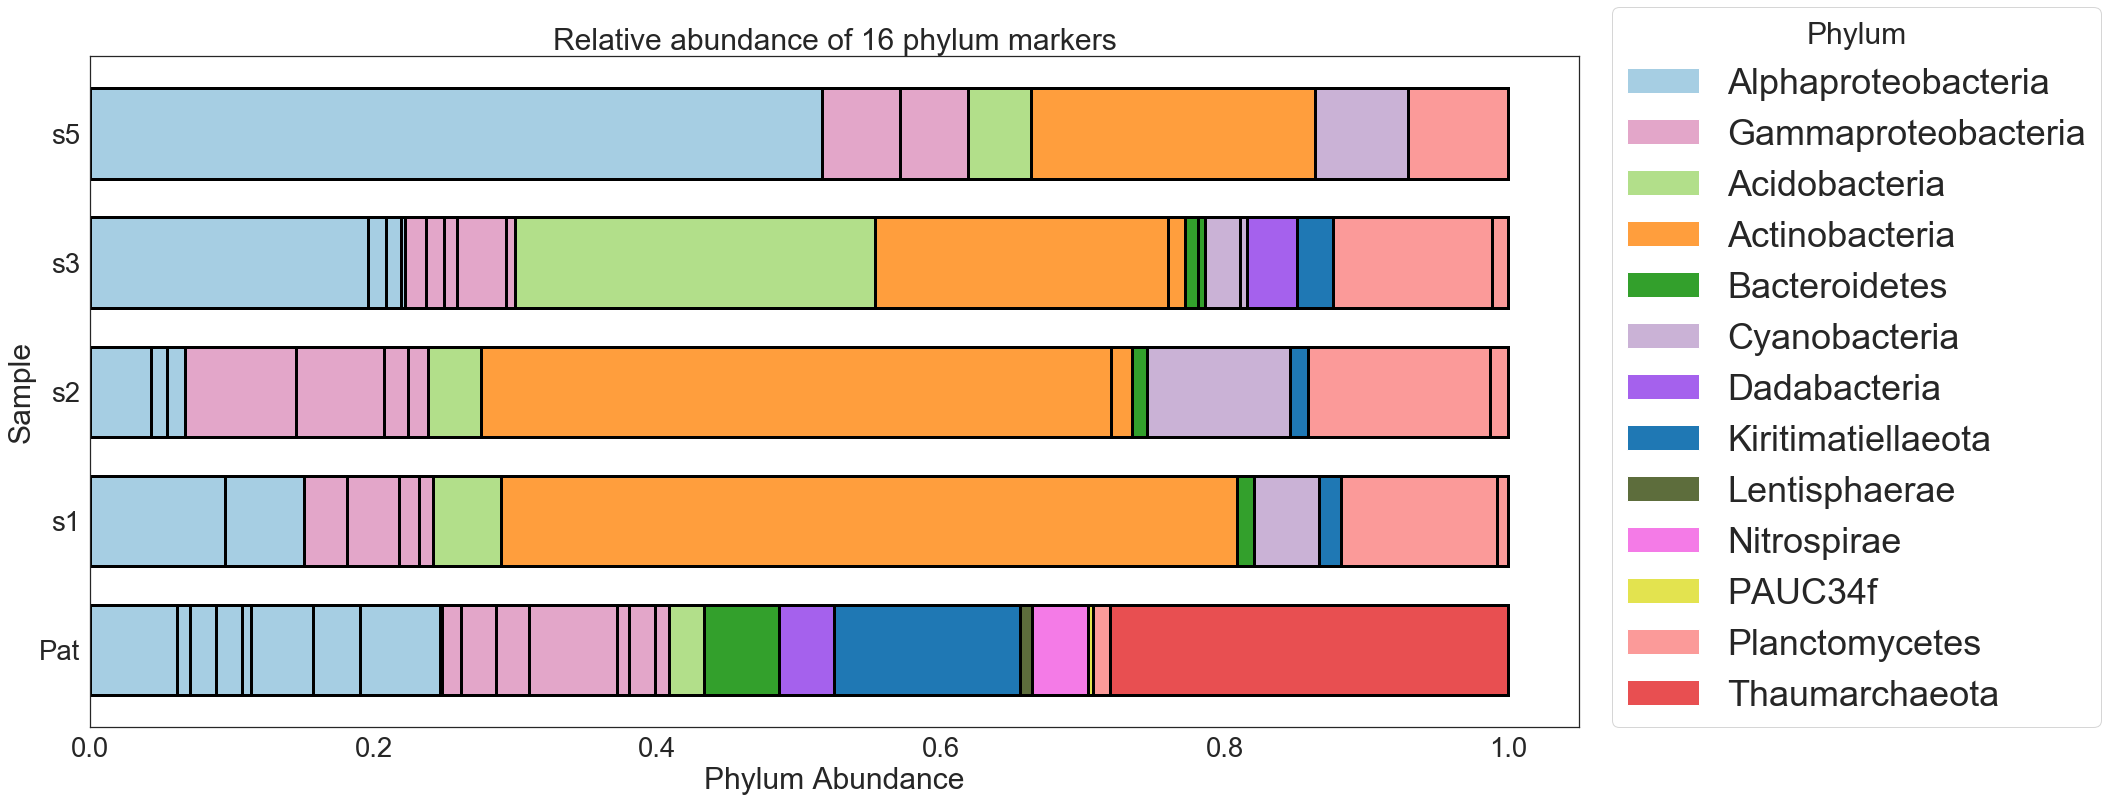

In [10]:
## Recombine to a df on structured for a stacked plot
data_frame_seqs_zeros = pd.DataFrame(data_sets, index=samples)

##plot

sns.set(font_scale = 2.5)
sns.set_style("white")

fig, ax = plt.subplots()


data_frame_ord.plot.barh(stacked=True, 
                         ax = ax,          ## this line makes the plots on the same axis 
                         figsize=(30,11.8), 
                         color=[v for k,v in color_map.items()], 
                         width = 0.7,
                         legend = False)



data_frame_seqs_zeros.plot.barh(stacked = True,
                                ax= ax,
                                width = 0.7,
                                legend = False,
                                figsize=(30,11.8),
                                edgecolor='black',
                                linewidth='3',
                                facecolor="None",
                               )


plt.ylabel('Sample')

plt.legend([k for k,v in color_map.items()], bbox_to_anchor=(1.01, 1.1), loc=2, title="Phylum", fontsize = 36)


plt.xlabel('Phylum Abundance')
plt.title('Relative abundance of 16 phylum markers')
plt.tight_layout()

plt.savefig('phylo_bar_divs.png', transparent=True)

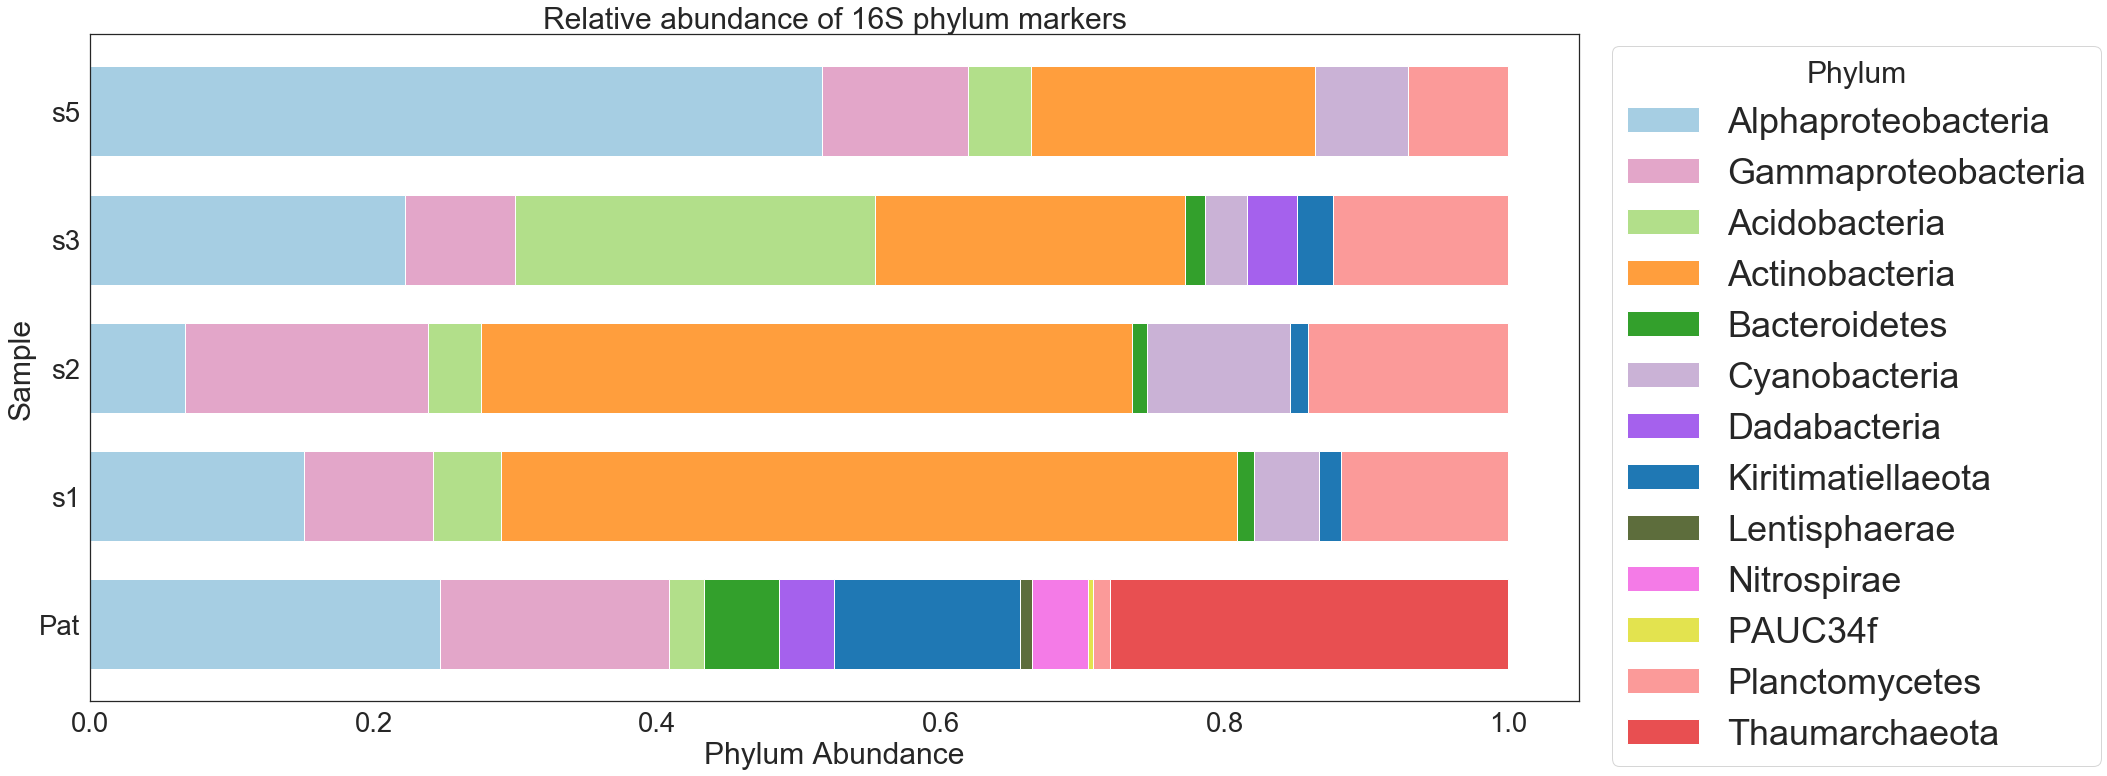

In [11]:

sns.set(font_scale = 2.5)
sns.set_style("white")

fig = data_frame_ord.plot.barh(stacked=True, 
                                     figsize=(30,11.8), 
                                     color=[v for k,v in color_map.items()], 
                                     width = 0.7,
                                     legend = False)


plt.legend([k for k,v in color_map.items()], bbox_to_anchor=(1.01, 1.01), loc=2, title="Phylum", fontsize = 36)
plt.ylabel('Sample')

plt.xlabel('Phylum Abundance')
plt.title('Relative abundance of 16S phylum markers')

plt.tight_layout()
plt.savefig('phylo_bar_char.png')

#plt.show()